In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [49]:
from IPython.display import display_html

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100, "display.width",200, "display.max_colwidth",40)
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import re
from datetime import date
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn.metrics
import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARN
import lightgbm as lgb; lgb.__version__
import pickle
import requests as r
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import class_weight
import collections
from binary_label_metrics import BinaryLabelMetrics


for x in [("numpy","np"),("pandas","pd")]:
  print(f"{x[0]} {eval(f'{x[1]}.__version__')}")

'3.2.1'

numpy 1.21.2
pandas 1.4.1


In [50]:
prm = dict(
  #number of Optuna trials
  NTRIALS = 20,
  
  #number of boosted trees to be created
  NBOOST = 50,

  #number of classes in response variable
  NCLASS = 2,

  #morgan fingerpring bit length
  FP_BITS = 256
)

offs = max(map(len,prm.keys()))
print("Parameters")
for k,v in prm.items():
  print(f"{k:>{offs}}: {v}")

del k, v, offs

Parameters
NTRIALS: 100
 NBOOST: 50
 NCLASS: 2
FP_BITS: 256


Reading Data

In [51]:
input_df = pd.read_csv("data/protac/protac.csv").reset_index(drop=True)
input_df = input_df.rename(columns={"E3 ligase":"E3ligase"})
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

print("Counts of distinct values in columns")
for x in ["Target","E3ligase"]:
  tmp = input_df.groupby(x, as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
  print(f"col:{x}  (#unique:{tmp.shape[0]:,})")
  print(tmp.head(20).T, "\n")

input_df: 5,388 x 83 (input df) 

Counts of distinct values in columns
col:Target  (#unique:323)
         0     1    2     3    4     5    6        7     8     9       10    11    12     13                14    15    16         17    18    19
Target   AR  BRD4   ER  CDK4  BTK  CDK6  ALK  BCR-ABL  BRD2  BRD3  BCL-xL  CDK9  MDM2  HDAC6  EGFR L858R/T790M  MEK1  CDK2  EGFR e19d  AKT3  AKT2
size    248   222  183   147  146   143  120      118   106    98      96    92    89     78                76    76    74         65    64    64 

col:E3ligase  (#unique:13)
            0     1      2     3     4    5    6      7       8       9       10      11    12
E3ligase  CRBN   VHL  cIAP1  MDM2  XIAP  IAP  AhR  FEM1B  DCAF15  DCAF16  RNF114  DCAF11  RNF4
size      3530  1578     95    56    49   46    9      9       4       4       4       3     1 



Creating E3 Ligase Classes

In [52]:
for i in range(len(input_df["E3ligase"])):
    if 'IAP' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='IAP'
    elif 'DCAF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='DCAF'
    elif 'RNF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='RNF'

tmp = input_df.groupby('E3ligase', as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
print(f"col:{'E3ligase'}  (#unique:{tmp.shape[0]:,})")
print(tmp.head(20).T, "\n")
del tmp

col:E3ligase  (#unique:8)
             0     1    2     3     4    5      6    7
E3ligase  CRBN   VHL  IAP  MDM2  DCAF  AhR  FEM1B  RNF
size      3530  1578  190    56    11    9      9    5 



In [53]:
print('Number of Rows with explicit DC50: ' + str((input_df.shape[0] - input_df['DC50 (nM)'].isna().sum())))
#input_df = input_df.dropna(subset=['DC50 (nM)',"Percent degradation (%)"],how='all')
input_df = input_df.dropna(subset=['DC50 (nM)'])
input_df = input_df.dropna(subset=['Uniprot'])
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

Number of Rows with explicit DC50: 905
input_df: 833 x 83 (input df) 



In [54]:
# lst = input_df['Smiles'].tolist()
# with open ('visualize_smi.smi','w') as f:
#     for line in lst:
#         f.write(line + '\n')

Preparing Features

E3 Ligase

In [55]:
model_df = pd.concat([
    pd.get_dummies(input_df["E3ligase"], prefix="e3"),
    input_df["Smiles"]
  ], axis=1).reset_index(drop=True)

print("model_df: {:,} x {:,}".format(*model_df.shape), "(E3ligase OHE features)")

model_df: 833 x 6 (E3ligase OHE features)


Receptor Sequence

In [56]:
cID= list(set(input_df['Uniprot'].tolist()))
seqs = {}

for c in cID:
    try:
        baseUrl="http://www.uniprot.org/uniprot/"
        currentUrl=baseUrl+c+".fasta"
        response = r.post(currentUrl)
        cData=''.join(response.text)
        i = cData.index('\n')+1
        seq = cData[i:].strip()
        seqs[c] = seq
    except:pass

In [57]:
input_df["rec_seq"] = input_df.apply(lambda row: seqs[row["Uniprot"]], axis=1)
model_df = model_df.assign(rec_seq = input_df["rec_seq"].tolist())
print("model_df: {:,} x {:,}".format(*model_df.shape), "(rec seq feature)")

model_df: 833 x 7 (rec seq feature)


Molecular Fingerprint (Ligand)

In [58]:
def get_morgan_fp(smiles:str, nbits:int=prm["FP_BITS"]):
  m = Chem.MolFromSmiles(smiles)
  fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nbits)
  array = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fingerprint, array)
  return array

fingerprints = [get_morgan_fp(x).tolist() for x in input_df["Smiles"]]
fp_df = pd.DataFrame(fingerprints, columns=["sm"+str(n) for n in range(1,prm["FP_BITS"]+1)])
print("model_df: {:,} x {:,}".format(*model_df.shape))

#assert model_df.columns == smiles_df.columns

model_df = pd.concat([model_df,fp_df],axis=1)
print("fp_df: {:,} x {:,}".format(*fp_df.shape))
print("model_df: {:,} x {:,}".format(*model_df.shape), "(added fingerprint features)")

model_df: 833 x 7
fp_df: 833 x 256
model_df: 833 x 263 (added fingerprint features)


Cell Type

In [59]:
celltypes = []
for i in range(input_df.shape[0]):
    row = str(input_df.iloc[i].to_list())
    cell = re.findall('[\w\.;/-]+ cells', row)
    if len(cell)==0:
        celltypes.append('Unknown')
    else:
        celltypes.append(cell[0][:-6])

def most_frequent(List):
    return max(set(List), key = List.count)

print("Most Common Cell Type: " + most_frequent(celltypes))

len(set(celltypes))
model_df['ct'] = celltypes
ct_df = pd.get_dummies(model_df['ct'], prefix='ct')
print("model_df: {:,} x {:,}".format(*model_df.shape))
model_df = pd.concat([model_df,ct_df],axis=1)
print("ct_df: {:,} x {:,}".format(*ct_df.shape))
print("model_df: {:,} x {:,}".format(*model_df.shape), "(added cell type OHE features)")

Most Common Cell Type: SRD15


148

model_df: 833 x 264
ct_df: 833 x 148
model_df: 833 x 412 (added cell type OHE features)


Response Variable (DC50)

In [60]:
#add and process DC50 column

model_df['resp'] = list(input_df['DC50 (nM)'])
model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")
model_df = model_df.loc[~model_df['resp'].str.contains('[a-zA-Z]')]

/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_33314/1778872113.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_33314/1778872113.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_33314/1778872113.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")


Split DC50 by Cell Type

In [61]:
out_nochange = []
out_v1 = []
out_v2 = []
for row in model_df.to_dict(orient="records"):
  #no slashes
  if "/" not in row["resp"]:
    out_nochange.append(row)
    continue
  
  #slashes in resp matched by a column with ct which has same number of slashes
  lst = [k for k,v in row.items() if k.startswith("ct") and "/" in k and v==1]
  assert len(lst) in [0,1]
  if len(lst) == 1:
    #test.append((lst[0],row["resp"]))
    cols = lst[0].split("/")
    vals = row["resp"].split("/")
    # assert len(cols)==len(vals)
    # assert len(cols) in [2,3]
    
    #adding 2 or 3 rows
    for c,v in zip(cols,vals):
      dct = row.copy()
      k = c if c.startswith("ct_") else "ct_"+c
      dct[k] = 1
      dct["resp"] = v
      del dct[lst[0]]
      out_v1.append(dct)
  else:
    vals = row["resp"].split("/")
    dct = row.copy()
    dct["resp"] = vals[0]
    out_v2.append(dct)
    
model_df = pd.DataFrame(out_nochange+out_v1+out_v2)
model_df = model_df.fillna(0)
model_df['resp'] = pd.to_numeric(model_df['resp'])
model_df = model_df.drop(['ct'],axis=1)

DC50 Distribution

[Text(0.5, 0, 'DC50 Value')]

[Text(0, 0.5, 'Count')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


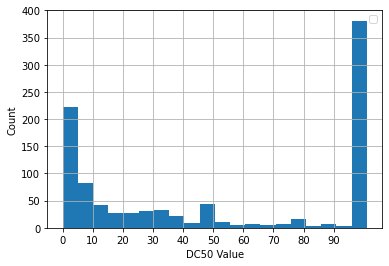

In [62]:
#dropping rows with outlier DC50 values
model_df.drop(model_df.index[model_df['resp'] <= 0], inplace=True)
model_df.loc[model_df.resp>100, 'resp'] = 101

ax = model_df['resp'].astype(float).hist(bins = 20)
ax.set(xlabel=f"DC50 Value")
ax.set(ylabel=f"Count")
ax.legend(loc="upper right")
ax.set_xticks(ticks=range(0, 100, 10), minor=False)

In [63]:
model_df.loc[model_df.resp<=100.0, 'resp_categorical'] = '1'
#model_df.loc[(model_df.resp<=100.0).any() and (model_df.resp>10.0).any(), 'resp_categorical'] = '1'
#model_df.loc[model_df.resp>100.0, 'resp_categorical'] = '0'
model_df['resp_categorical'] = model_df['resp_categorical'].fillna('0')
model_df.drop(model_df.tail(1).index,inplace=True) # drop last row of nans
print("model_df: {:,} x {:,}".format(*model_df.shape))

model_df: 987 x 472


In [64]:
model_df['rec_seq'] = model_df['rec_seq'].apply(lambda x: " ".join(x))
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b',ngram_range=(2,3))
X = vectorizer.fit_transform(model_df['rec_seq'].tolist())
vectorizer.get_feature_names_out()

array(['a a', 'a a a', 'a a c', ..., 'y y v', 'y y w', 'y y y'],
      dtype=object)

In [65]:
rec_n_grams_df = pd.DataFrame(X.toarray(),columns=list(s.replace(" ", "") for s in vectorizer.get_feature_names_out()))
print("model_df: {:,} x {:,}".format(*model_df.shape))
model_df = pd.concat([model_df,rec_n_grams_df],axis=1)
print("rec_n_grams_df: {:,} x {:,}".format(*rec_n_grams_df.shape))
print("model_df: {:,} x {:,}".format(*model_df.shape), "(added n-gram features)")

model_df: 987 x 472
rec_n_grams_df: 987 x 7,841
model_df: 989 x 8,313 (added n-gram features)


In [66]:
visualization_df = model_df[['Smiles','resp_categorical']]
visualization_df.to_csv('visualization_true.csv',index=False)

In [67]:
model_df = model_df.drop(["rec_seq",'Smiles'],axis=1)
model_df.drop(model_df.tail(4).index, inplace = True)

In [68]:
resp_col = model_df.pop('resp_categorical')
model_df['resp_categorical'] = resp_col #to add to end

Model Matrices

In [69]:
train,test = train_test_split(model_df, random_state=1, test_size=.2)

features = train.columns.tolist()[1:-1]  #dropping "resp_categorical, resp still there"
print(f"nfeatures: {len(features):,}")

X_train = train.drop(["resp_categorical","resp"], axis=1).values
print("x train before: {:,} x {:,}".format(*X_train.shape), "(x df) \n")
y_train = train["resp_categorical"].values
y_train = np.array([int(x) for x in y_train])

X_test = test.drop(["resp_categorical","resp"], axis=1).values
y_test = test["resp_categorical"].values
y_test = np.array([int(x) for x in y_test])

del train, test

#save features to a pickle file
with open("features","wb") as feat_file:
    pickle.dump(features, feat_file)

nfeatures: 8,309
x train before: 788 x 8,309 (x df) 



In [70]:
print("[train] X: {:,} x {:,}".format(*X_train.shape,y_train.shape))
print("[test] X: {:,} x {:,}".format(*X_test.shape,y_train.shape))

[train] X: 788 x 8,309
[test] X: 197 x 8,309


Hyperparameter Optimization

In [71]:
class LightGBM:
  
  def __init__(self):
    self.best_booster = None
    self._booster = None
    
    self.X = X_train
    self.y = y_train
    self.nclass = 2
    #self.wts = class_weight.compute_sample_weight(class_weight="balanced", y=self.y)
    self.prm_lgb = {      
      "objective": "multiclass" if self.nclass>2 else "binary",
      "metric": None, 
      "verbosity": -1,
      #"num_class": self.nclass,
      "boosting_type": "gbdt",
      "force_row_wise": True,
      "min_gain_to_split": .5,
    }
  
  def __call__(self, trial):    
    dtrain = lgb.Dataset(self.X, self.y)
    prm_lgb = {
      **self.prm_lgb
      , **{
        "learning_rate": trial.suggest_loguniform("learning_rate", .01, .3),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1E-3, 1.),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", .5, 3.),
        "num_leaves": trial.suggest_int("num_leaves", 8, 32),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", .3, .6),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", .4, 1.),
        "bagging_freq": trial.suggest_int("bagging_freq", 2, 6),
        "boosting_type":trial.suggest_categorical("boosting_type",["gbdt","rf"])
      }
    }
    
    if self.nclass>2:
      def f1_eval(preds,dataset):
        f_score = f1_score(dataset.get_label(),preds.reshape(-1,self.nclass).argmax(axis=1),average="micro")
        return "f1_score",f_score,True
    else:
      def f1_eval(preds,dataset):
        pred1 = np.zeros(dataset.get_label().shape[0],dtype=int); pred1[-dataset.get_label().sum().astype(int):] = 1
        f_score = f1_score(dataset.get_label()[preds.argsort()],pred1,average="micro")
        return "f1_score",f_score,True
    
    early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=False)
    eval_hist = lgb.cv(prm_lgb, dtrain, nfold=5, seed=12345, num_boost_round=prm["NBOOST"],
                           feval=f1_eval, callbacks=[early_stop])
    
    return eval_hist["f1_score-mean"][-1]
  
  def callback(self, study, trial):
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_booster = self._booster
      return
    if trial.number%20==0:
      print(f"{trial.number}", end=" ", flush=True)

  
objective = LightGBM()
print(f"best trial ({prm['NTRIALS']}):", end=" ")
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                              sampler=optuna.samplers.TPESampler(seed=1234), direction="maximize")
study.optimize(objective, n_trials=prm["NTRIALS"], callbacks=[objective.callback])

best trial (100): 0 (0.744) 6 (0.754) 10 (0.805) 14 (0.815) 15 (0.825) 17 (0.827) 20 40 60 80 

In [72]:
trials_df = study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  trials_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in trials_df.columns]
trials_df["duration"] = trials_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",6, "display.float_format","{:.4f}".format):
  display_html(trials_df.sort_values("value", ascending=False))
print(f"  duration: {trials_df['duration'].sum()/60:.1f}min")

trials_df.groupby("boosting_type").agg(meanv=("value","mean"),sdv=("value","std"))

,bagging_fraction,bagging_freq,boosting_type,feature_fraction,lambda_l1,lambda_l2,learning_rate,min_data_in_leaf,num_leaves,value,duration
17,0.7965,3,gbdt,0.4066,0.2141,0.6424,0.2668,64,22,0.8274,3.3550
83,0.7640,5,gbdt,0.4838,0.0076,0.5644,0.2793,59,27,0.8249,4.0360
22,0.9183,3,gbdt,0.4182,0.4161,0.6330,0.2851,57,27,0.8249,2.6487
...,...,...,...,...,...,...,...,...,...,...,...
4,0.4260,4,rf,0.4600,0.0036,0.5443,0.0123,80,24,0.7132,2.8170
2,0.6383,5,rf,0.4954,0.0702,0.5723,0.0346,97,17,0.7005,1.1782
3,0.5313,6,rf,0.5114,0.0203,2.1046,0.1922,85,11,0.6955,2.8018


  duration: 5.1min


,meanv,sdv
boosting_type,,
gbdt,0.803538,0.022633
rf,0.731002,0.016064


In [73]:
print("Best Boosted Tree Model Mean F1 Score (Train): " + str(trials_df[trials_df['boosting_type']=='gbdt']['value'].max()))
print("Best Random Forest Model Mean F1 Score (Train): " + str(trials_df[trials_df['boosting_type']=='rf']['value'].max()))

Best Boosted Tree Model Mean F1 Score (Train): 0.8274288478593889
Best Random Forest Model Mean F1 Score (Train): 0.7488027090220108


In [74]:
ind = np.argmax(trials_df["value"].values)
lgb_prm = study.trials[ind].params
lgb_prm = {**lgb_prm, 
  **{
    "objective": "multiclass",
    "metric": None,
    "num_class": 2,
    "force_row_wise": True, 
    "verbosity": -1,
    "min_gain_to_split": .5,
  }
}

def f1_eval(preds, dtrain):
  preds = preds.reshape(prm['NCLASS'],-1).T
  f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
  return "f1_score",f_score,True

wt = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)
dtrain = lgb.Dataset(X_train, y_train, weight=wt)
#early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=True)
model = lgb.train(lgb_prm, dtrain, feval=f1_eval,
                      num_boost_round=prm["NBOOST"])

del ind, lgb_prm, wt

Metrics on Hold-Out Test Set

In [75]:
y_hat = model.predict(X_test)
y_hat = np.array([val[1] for val in y_hat])
print(y_hat.shape, y_test.shape)
scores_df = pd.DataFrame({'label':list(y_test),'score':list(y_hat)})

(197,) (197,)


In [76]:
blm = BinaryLabelMetrics()
blm.add_model('binary_gbm', scores_df)

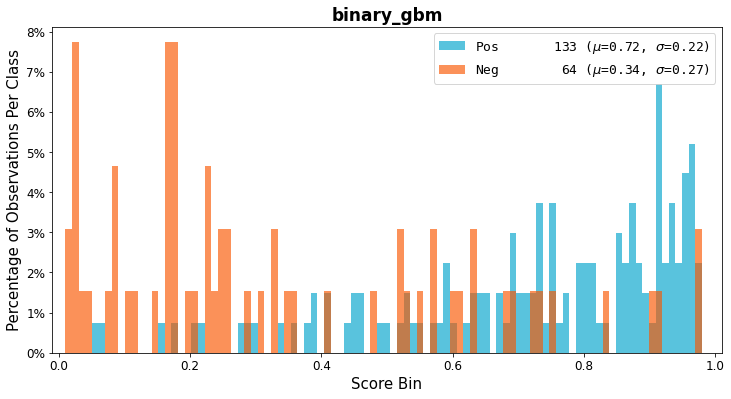

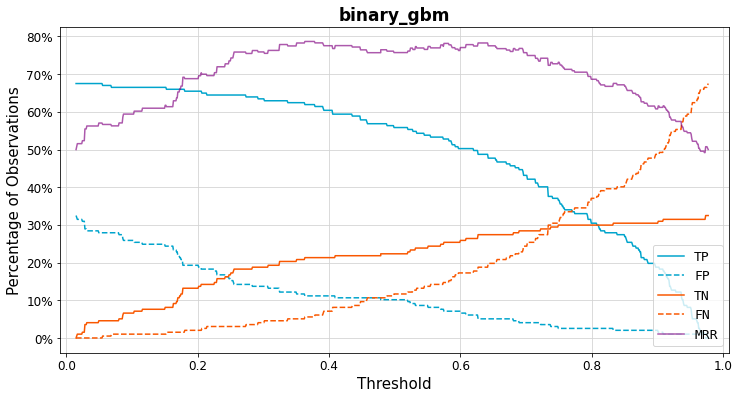

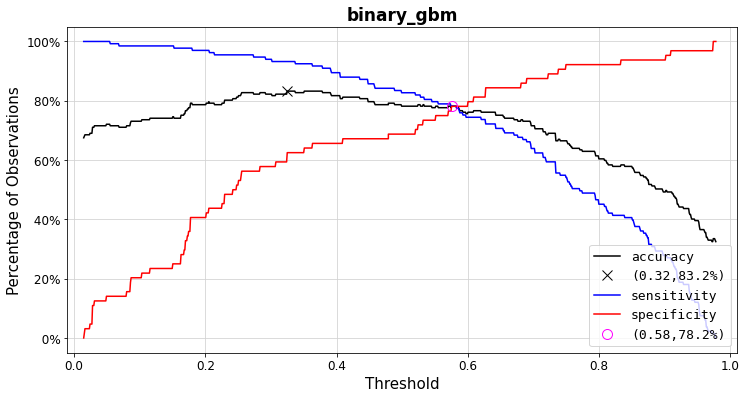

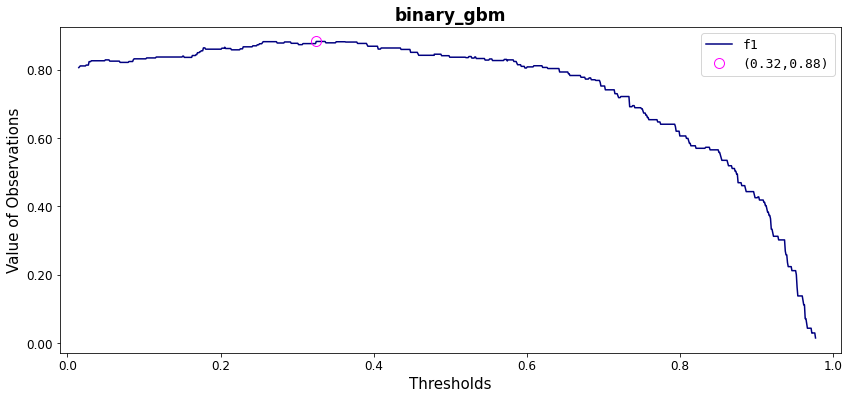

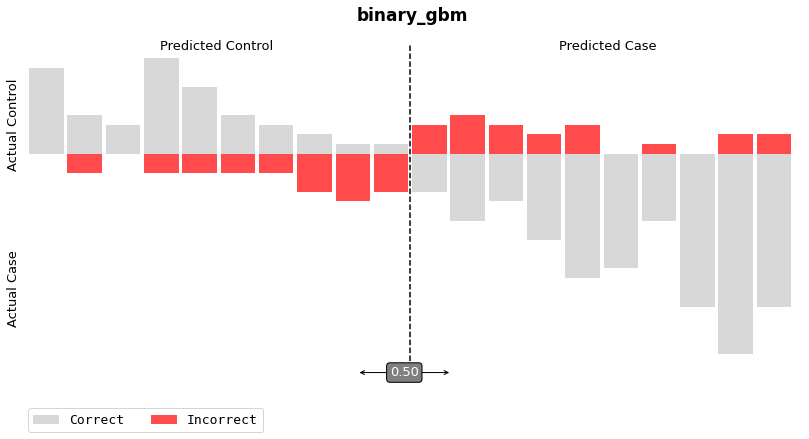

In [77]:
blm.plot()

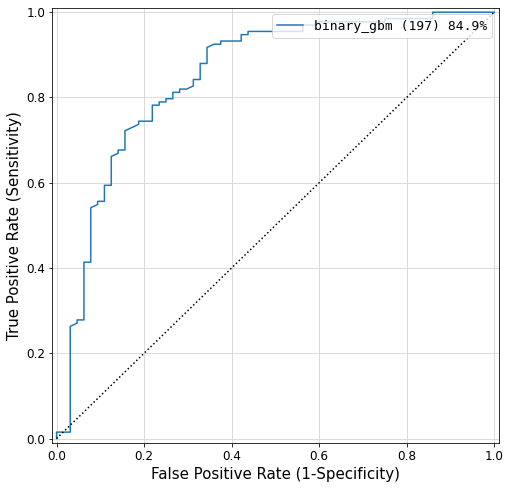

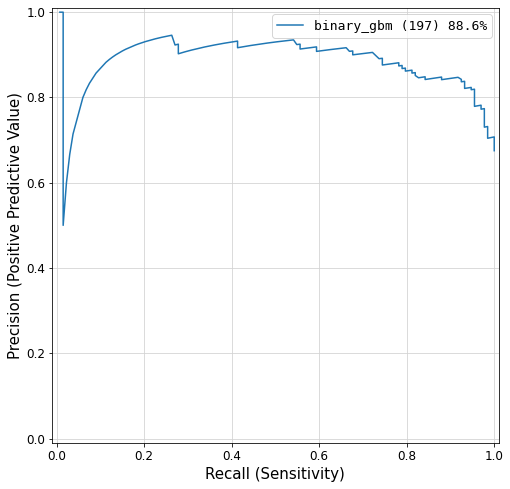

In [78]:
blm.plot_roc()

In [79]:
# Pkl_Filename = f"output_0731/Protac_Scoring_Model_{prm['FP_BITS']}.pkl"  

# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(model, file)

In [80]:
# Feature_Filename = f"output_0731/features_{prm['FP_BITS']}.pkl"  
# features = model_df.columns.tolist()[:-1]

# with open(Feature_Filename, 'wb') as file:  
#     pickle.dump(features, file)